# NEWS SENTIMENT ANALYSIS - ETL-Pipeline using KAFKA-HADOOP-SPARK 

In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StopWordsRemover, Tokenizer, Word2Vec
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, when
import json

In [2]:
# spark = SparkSession.builder.master("spark://localhost:7077").appName("News Sentiment analysis").getOrCreate()
spark = SparkSession.builder.master("local[*]").appName("News Sentiment analysis").getOrCreate()
spark

23/12/22 05:55:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Load data from HDFS

In [3]:
hdfsPath = "hdfs://namenode:9000/user/spark/news_data_articles.txt"
df = spark.read.json(hdfsPath)

In [4]:
df.show()

+-------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
| author|             content|         description|       published_at|              source|               title|                 url|        url_to_image|
+-------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|bbcnews|Thirty years afte...|The BBC's Fergal ...|2023-12-03 22:21:04|[bbc-news, BBC News]|South Africa: The...|https://www.bbc.c...|https://ichef.bbc...|
|bbcnews|South Florida. A ...|The Grand Theft A...|2023-12-10 00:56:54|[bbc-news, BBC News]|Grand Theft Auto ...|https://www.bbc.c...|https://ichef.bbc...|
|bbcnews|The families of t...|Police in Vermont...|2023-11-27 00:31:15|[bbc-news, BBC News]|Vermont: Three Pa...|https://www.bbc.c...|https://ichef.bbc...|
|bbcnews|Homosexuality sho...|Cardinal Peter Tu...|2023-11-27 12

# Data Preparation

In [5]:
labeled_data = df.withColumn("label", when(lower(df["description"]).contains("crime") |
                                            lower(df["description"]).contains("murder") |
                                            lower(df["description"]).contains("robbery"), 1).otherwise(0))
labeled_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   65|
|    0|  546|
+-----+-----+



### Define a function to convert text to lowercase and tokenize it

In [6]:
def tokenize_text(df):
    tokenizer = Tokenizer(inputCol="description", outputCol="words")
    return tokenizer.transform(df)

In [7]:
tokenizer = Tokenizer(inputCol="description", outputCol="words")
tokenized_data = tokenize_text(labeled_data)
tokenized_data.show()

+-------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+
| author|             content|         description|       published_at|              source|               title|                 url|        url_to_image|label|               words|
+-------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+
|bbcnews|Thirty years afte...|The BBC's Fergal ...|2023-12-03 22:21:04|[bbc-news, BBC News]|South Africa: The...|https://www.bbc.c...|https://ichef.bbc...|    0|[the, bbc's, ferg...|
|bbcnews|South Florida. A ...|The Grand Theft A...|2023-12-10 00:56:54|[bbc-news, BBC News]|Grand Theft Auto ...|https://www.bbc.c...|https://ichef.bbc...|    0|[the, grand, thef...|
|bbcnews|The families of t...|Police in Vermont...|2023-11-27 00:31:15|[bbc-news, BBC

### Define the StopWordsRemover and Create the "filteredWords" column

In [8]:
remover = StopWordsRemover(inputCol="words", outputCol="filteredWords")
filtered_data = remover.transform(tokenized_data)
filtered_data.show()

+-------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+
| author|             content|         description|       published_at|              source|               title|                 url|        url_to_image|label|               words|       filteredWords|
+-------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+
|bbcnews|Thirty years afte...|The BBC's Fergal ...|2023-12-03 22:21:04|[bbc-news, BBC News]|South Africa: The...|https://www.bbc.c...|https://ichef.bbc...|    0|[the, bbc's, ferg...|[bbc's, fergal, k...|
|bbcnews|South Florida. A ...|The Grand Theft A...|2023-12-10 00:56:54|[bbc-news, BBC News]|Grand Theft Auto ...|https://www.bbc.c...|https://ichef.bbc...|    0|[the, grand, thef...|[g

### Create a Word2Vec model

In [9]:
word2Vec = Word2Vec(inputCol="filteredWords", outputCol="features", vectorSize=100, minCount=0)

# Model Training

### Create a RandomForestClassifier

In [10]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10, rawPredictionCol="rawPrediction")


### Create a pipeline with the stages

In [11]:
pipeline = Pipeline(stages=[tokenizer, remover, word2Vec, rf])

### Split the data into training and testing sets

In [12]:
training_data, test_data = labeled_data.randomSplit([0.7, 0.3], seed=12345)


### Train the model

In [13]:
model = pipeline.fit(training_data)

23/12/22 05:55:25 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/12/22 05:55:25 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


## Make predictions on the test set

In [14]:
predictions = model.transform(test_data)

## Evaluate the model

In [15]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [16]:
accuracy = evaluator.evaluate(predictions)
accuracy

0.8806818181818182

# Save the model

In [17]:
from datetime import datetime 
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
save_path=f"hdfs://namenode:9000/user/spark/saved_models/news_sentiment_multi_classification_model_{timestamp}"

In [18]:
model.save(save_path)

23/12/22 05:55:30 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/12/22 05:55:30 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/12/22 05:55:30 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/12/22 05:55:30 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/12/22 05:55:30 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/12/22 05:55:30 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/12/22 05:55:30 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

# Load the model and predict the latest news result

In [19]:
from pyspark.ml import PipelineModel

In [20]:
loaded_model = PipelineModel.load(save_path)

In [21]:
# Make predictions on new data
hdfsPath = "hdfs://namenode:9000/user/spark/news_data_articles.txt"
new_data = spark.read.json(hdfsPath)

labeled_data = df.withColumn("label", when(lower(df["description"]).contains("crime") |
                                            lower(df["description"]).contains("murder") |
                                            lower(df["description"]).contains("robbery"), 1).otherwise(0))
new_predictions = loaded_model.transform(labeled_data)

# Evaluate the predictions on new data (if ground truth labels are available)
new_accuracy = evaluator.evaluate(new_predictions)

In [22]:
new_accuracy

0.9083469721767594

# Post Predictions

### Evaluate the model using relevant metrics and visualization

In [23]:
from pyspark.mllib.evaluation import MulticlassMetrics

prediction_and_label = predictions.select("prediction", "label").rdd.map(lambda row: (float(row["prediction"]), float(row["label"])))

# Create MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_label)

# Overall statistics
print(f"Precision: {metrics.precision(1.0)}")
print(f"Recall: {metrics.recall(1.0)}") 
print(f"F1 Score: {metrics.fMeasure(1.0)}") 
print(f"Accuracy: {metrics.accuracy}")


# from pyspark.mllib.evaluation import BinaryClassificationMetrics
# prediction_and_label = predictions.select("rawPrediction", "label").rdd.map(lambda row: (float(row["rawPrediction"][1]), float(row["label"])))
# metrics = BinaryClassificationMetrics(predictions_and_labels)
# print(f"Area under ROC: {metrics.areaUnderROC}")
# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Accuracy: 0.8806818181818182


In [24]:
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,roc_curve

### Confusion Matrix
 Examine the confusion matrix to understand the distribution of true positives, true negatives, false positives, and false negatives.

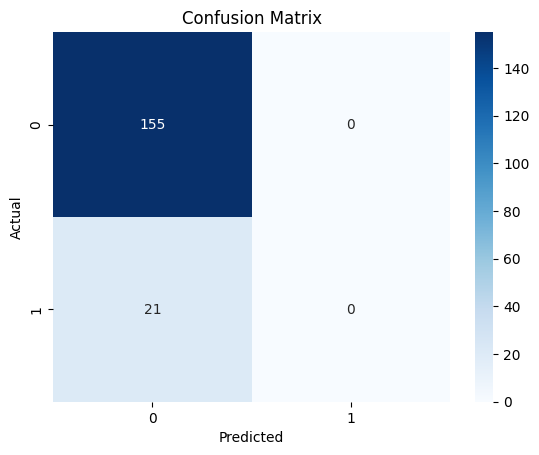

In [25]:
conf_matrix = confusion_matrix(predictions.select("label").collect(), predictions.select("prediction").collect())
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Interpretation
inspect feature importance scores to understand which features contribute most to predictions.

In [26]:
feature_importances = model.stages[-1].featureImportances.toArray()
print("Feature Importances:")
for i, importance in enumerate(feature_importances):
    print(f"Feature {i + 1}: {importance}")

Feature Importances:
Feature 1: 0.015051080097373496
Feature 2: 0.0002873794110582124
Feature 3: 0.01332814031334399
Feature 4: 0.0
Feature 5: 0.0
Feature 6: 0.0
Feature 7: 0.019113264004936917
Feature 8: 0.015064460075717984
Feature 9: 0.014789811418442484
Feature 10: 0.012263786258543456
Feature 11: 0.0036664835219485485
Feature 12: 0.0
Feature 13: 0.010282457713879428
Feature 14: 0.0
Feature 15: 0.0037138960905618843
Feature 16: 0.0
Feature 17: 0.005921216051342099
Feature 18: 0.015603721533278981
Feature 19: 0.00433138753162371
Feature 20: 0.0
Feature 21: 0.0
Feature 22: 0.017442331773253494
Feature 23: 0.0
Feature 24: 0.017086010558358226
Feature 25: 0.00382297876028498
Feature 26: 0.0
Feature 27: 0.0
Feature 28: 0.0
Feature 29: 0.009828777231717087
Feature 30: 0.0054620640660725285
Feature 31: 0.0071588129266852655
Feature 32: 0.019787704511670483
Feature 33: 0.011630586259748912
Feature 34: 0.0
Feature 35: 0.0123551217832904
Feature 36: 0.007273668455883249
Feature 37: 0.0
Featu

### Visualize

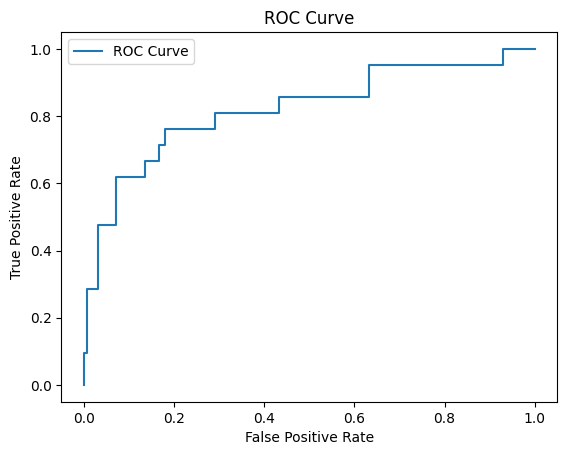

In [27]:
prediction_and_label = predictions.select("rawPrediction", "label").rdd.map(lambda row: (float(row["rawPrediction"][1]), float(row["label"])))


prediction_and_label_list = prediction_and_label.collect()

# Extract probabilities and labels
probabilities, labels = zip(*prediction_and_label_list)

# Calculate false positive rate (fpr) and true positive rate (tpr)
fpr, tpr, _ = roc_curve(labels, probabilities)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

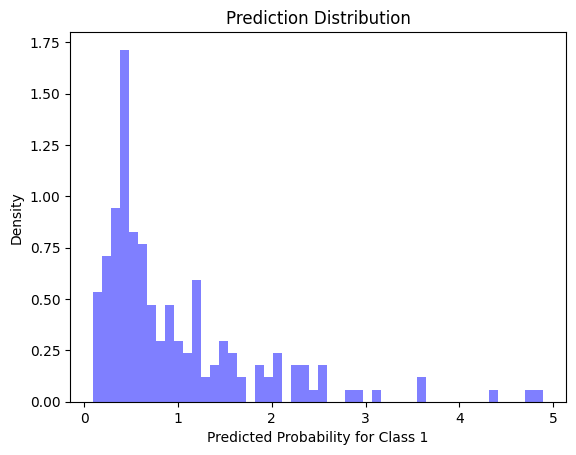

In [28]:
probabilities = predictions.select("rawPrediction").rdd.map(lambda row: float(row["rawPrediction"][1])).collect()

# Plot a histogram
plt.hist(probabilities, bins=50, density=True, alpha=0.5, color='b')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Density')
plt.title('Prediction Distribution')
plt.show()

In [29]:
spark.stop()